In [ ]:
# prompt: mount google drive, import numpy, load file dataset_4task_log10_11349samples_1858.npz located in My Drive, add test output, importing one of the files in it, which is aa 64x64 image, and plot it with matplotlib

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from matplotlib import pyplot as plt

data = np.load('/content/drive/My Drive/dataset_4task_log10_11349samples_1858.npz')
print(data.files) # Print the names of the files within the .npz archive

Mounted at /content/drive
['data', 'targets', 'redshifts', 'loaded_uids', 'target_scaler_params', 'redshift_scaler_params', 'fsub_scale_factor', 'image_scalers', 'image_min_values']


In [ ]:

import os
import numpy as np
import torch
from torch.utils.data import Dataset
# from torchvision import transforms # For augmentations

class ViTDatasetFromCache(Dataset):
    """
    Loads pre-processed data for a Vision Transformer from a .npz cache file.

    This class reads .npz files where the 'data' key contains images that have
    already been log-scaled and standardized. It loads regression 'targets'
    instead of classification 'labels'.
    """
    def __init__(self, npz_path, transform=None):
        """
        Initializes the dataset.

        Args:
            npz_path (str): Path to the .npz dataset cache file.
            transform (callable, optional): Optional augmentation transform to be
                                            applied on a sample (e.g., rotation).
        """
        self.transform = transform

        print(f"✅ Loading pre-processed dataset from cache: {npz_path}")
        if not os.path.exists(npz_path):
            raise FileNotFoundError(f"[ERROR] Dataset file not found: {npz_path}")

        # Load the entire cache file
        dataset_cache = np.load(npz_path, allow_pickle=True)

        # The 'data' in the cache is already processed.
        self.data = dataset_cache['data']

        # The cache contains 'targets' (for regression).
        self.targets = dataset_cache['targets']
        self.redshifts = dataset_cache['redshifts']

        # You can also load other metadata if your model needs it.
        # self.redshifts = dataset_cache['redshifts']
        # self.loaded_uids = dataset_cache['loaded_uids']

        print(f"   - Image data shape: {self.data.shape}")
        print(f"   - Target data shape: {self.targets.shape}")
        print(f"✅ Dataset ready. Total samples: {len(self.data)}")

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves one item (image and targets) from the dataset.
        """
        # Retrieve the pre-processed image data and regression targets
        image = torch.tensor(self.data[idx], dtype=torch.float32)
        targets = torch.tensor(self.targets[idx], dtype=torch.float32)
        redshifts = torch.tensor(self.redshifts[idx], dtype=torch.float32)

        # Apply on-the-fly augmentations if they are provided
        if self.transform:
            image = self.transform(image)

        # Note: This returns regression targets, not a classification label.
        return image, targets, redshifts

In [ ]:
# prompt: load dataset, split train and val by 0.85:0.15, make dataloadder

from torch.utils.data import DataLoader, random_split

# Assume data is loaded into MyDatasetViT instance
dataset = ViTDatasetFromCache('/content/drive/My Drive/dataset_4task_log10_11349samples_1858.npz')

# Define the split ratios
train_ratio = 0.85
val_ratio = 0.15

# Calculate the number of samples for each set
total_samples = len(dataset)
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"\n--- Dataset Split Complete ---")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Define DataLoader parameters
batch_size = 32  # You can adjust this based on your GPU memory and model size
num_workers = 2  # Number of subprocesses to use for data loading (set to 0 for debugging)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"\n--- DataLoaders Created ---")
print(f"Train DataLoader batches: {len(train_dataloader)}")
print(f"Validation DataLoader batches: {len(val_dataloader)}")



✅ Loading pre-processed dataset from cache: /content/drive/My Drive/dataset_4task_log10_11349samples_1858.npz
   - Image data shape: (11327, 4, 91, 91)
   - Target data shape: (11327, 4)
✅ Dataset ready. Total samples: 11327

--- Dataset Split Complete ---
Training samples: 9627
Validation samples: 1700

--- DataLoaders Created ---
Train DataLoader batches: 301
Validation DataLoader batches: 54


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class ResNet4Task(nn.Module):
    """
    ResNet-18 for 4-task prediction using images and redshift data.
    This version is corrected to ensure proper layer dimensions.
    """

    def __init__(self):
        super(ResNet4Task, self).__init__()

        # --- Image Backbone (ResNet-18) ---
        # Outputs a 512-dimension feature vector.
        self.image_resnet = resnet18(weights=None)
        self.image_resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.image_resnet.fc = nn.Identity()

        # --- Redshift Processing MLP ---
        # Outputs a 128-dimension feature vector.
        self.redshift_fc = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Combined Features MLP ---
        # Accepts the combined 640-dim vector (512 from image + 128 from redshift).
        self.shared_fc = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # --- Final Task-Specific Heads ---
        # Each head takes the 128-dim shared features as input.
        self.main_halo_head = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 1)
        )
        self.sigma_v_head = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 1)
        )
        self.subhalo_mass_head = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 1)
        )
        self.fsub_head = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 1)
        )

    def forward(self, images, redshifts):
        # 1. Process image -> (batch_size, 512)
        img_features = self.image_resnet(images)

        # 2. Process redshift -> (batch_size, 128)
        z_features = self.redshift_fc(redshifts)

        # 3. Combine features -> (batch_size, 640)
        combined = torch.cat([img_features, z_features], dim=1)

        # 4. Pass through shared MLP -> (batch_size, 128)
        shared = self.shared_fc(combined)

        # 5. Get predictions from each task head.
        #    DO NOT squeeze the last dimension. Keep shape as (batch_size, 1).
        main_halo = self.main_halo_head(shared)
        sigma_v = self.sigma_v_head(shared)
        subhalo_mass = self.subhalo_mass_head(shared)
        fsub = self.fsub_head(shared)

        # 6. Use torch.cat along dimension 1 to create the final (batch_size, 4) tensor.
        return torch.cat([main_halo, sigma_v, subhalo_mass, fsub], dim=1)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")

    model.to(device)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

        # --- Training Phase ---
        model.train()
        train_loss = 0.0

        for images, targets, redshifts in train_loader:
            images, targets, redshifts = images.to(device), targets.to(device), redshifts.to(device)

            optimizer.zero_grad()
            outputs = model(images, redshifts)

            # Calculate regression loss (e.g., MSE)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, targets, redshifts in val_loader:
                # Renamed 'labels' to 'targets'
                images, targets, redshifts = images.to(device), targets.to(device), redshifts.to(device)

                outputs = model(images, redshifts)
                loss = criterion(outputs, targets)

                val_loss += loss.item()

        # --- Epoch-level Metrics ---
        # For regression, the primary metric is the loss.
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f'\n[SUMMARY] Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')

        # --- Save Best Model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'lens_regressor_model.pth')
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")

    print("\nTraining Complete!")

In [ ]:
import torch.optim as optim
"""
Args:
        image_size (int): Size of the input image (e.g., 224).
        patch_size (int): Size of each patch (e.g., 16).
        in_channels (int): Number of input channels (e.g., 1 for your task).
        num_classes (int): Number of output classes (e.g., 3 for your task).
        embed_dim (int): The main embedding dimension (e.g., 768 for ViT-Base).
        depth (int): Number of Transformer Encoder blocks (e.g., 12 for ViT-Base).
        num_heads (int): Number of attention heads (e.g., 12 for ViT-Base).
        mlp_ratio (float): Ratio to determine MLP hidden dimension (e.g., 4.0).
        dropout (float): Dropout probability.
"""
from torch.optim.lr_scheduler import CosineAnnealingLR
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 250
# Initialize Model
model = ResNet4Task()


criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

print("Optimizer: Adam")
print(f"Learning Rate: {learning_rate}")

train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs)

Optimizer: Adam
Learning Rate: 0.001
✅ Training on device: cuda

===== Epoch 1/250 =====

[SUMMARY] Epoch 1/250:
Train Loss: 0.6293
Val Loss: 0.4631
✅ New best model saved with validation loss: 0.4631

===== Epoch 2/250 =====

[SUMMARY] Epoch 2/250:
Train Loss: 0.5480
Val Loss: 0.4662

===== Epoch 3/250 =====

[SUMMARY] Epoch 3/250:
Train Loss: 0.5137
Val Loss: 0.4559
✅ New best model saved with validation loss: 0.4559

===== Epoch 4/250 =====

[SUMMARY] Epoch 4/250:
Train Loss: 0.5206
Val Loss: 0.4291
✅ New best model saved with validation loss: 0.4291

===== Epoch 5/250 =====

[SUMMARY] Epoch 5/250:
Train Loss: 0.4898
Val Loss: 0.4715

===== Epoch 6/250 =====

[SUMMARY] Epoch 6/250:
Train Loss: 0.4909
Val Loss: 0.4158
✅ New best model saved with validation loss: 0.4158

===== Epoch 7/250 =====

[SUMMARY] Epoch 7/250:
Train Loss: 0.4780
Val Loss: 0.4321

===== Epoch 8/250 =====

[SUMMARY] Epoch 8/250:
Train Loss: 0.4559
Val Loss: 0.4837

===== Epoch 9/250 =====

[SUMMARY] Epoch 9/250:

TypeError: cannot unpack non-iterable NoneType object

In [ ]:

torch.save(model.state_dict(), 'lens_regressor_model.pth')


--- Metrics for Task: Main Halo Mass ---
R^2 Score: 0.6589
Mean Squared Error (MSE): 0.3393
Root Mean Squared Error (RMSE): 0.5825


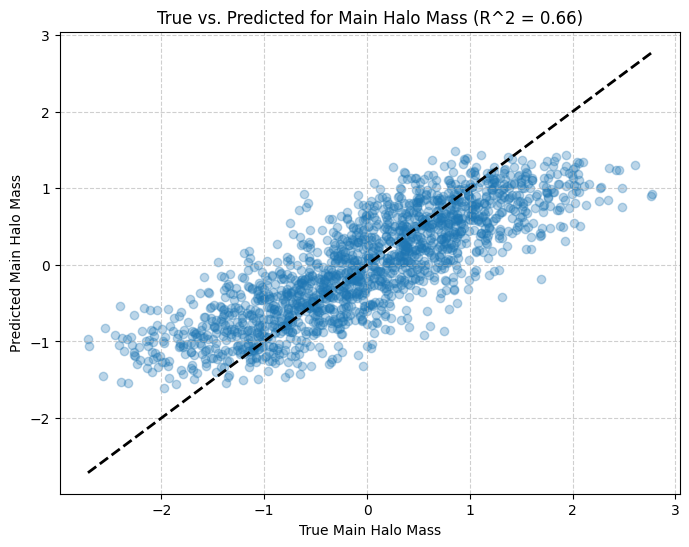

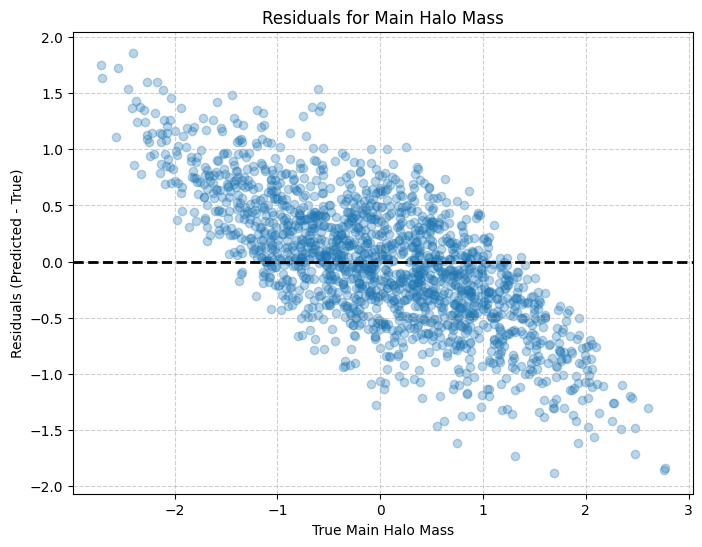


--- Metrics for Task: Sigma_v ---
R^2 Score: 0.8414
Mean Squared Error (MSE): 0.1546
Root Mean Squared Error (RMSE): 0.3931


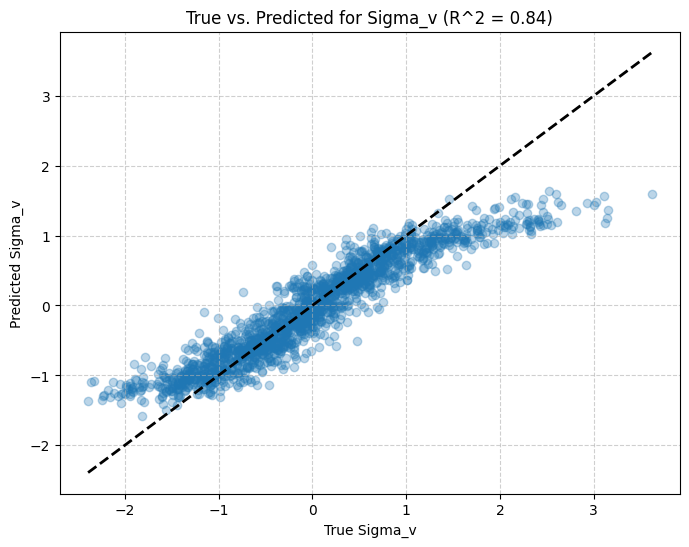

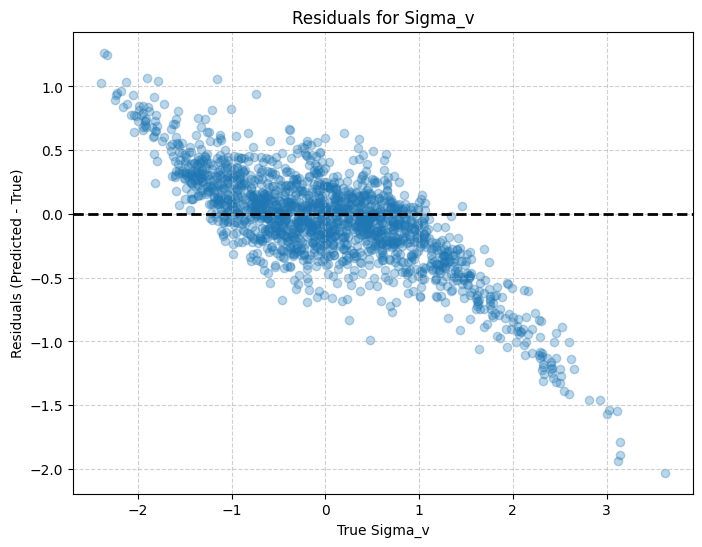


--- Metrics for Task: Subhalo Mass ---
R^2 Score: 0.4233
Mean Squared Error (MSE): 0.5751
Root Mean Squared Error (RMSE): 0.7583


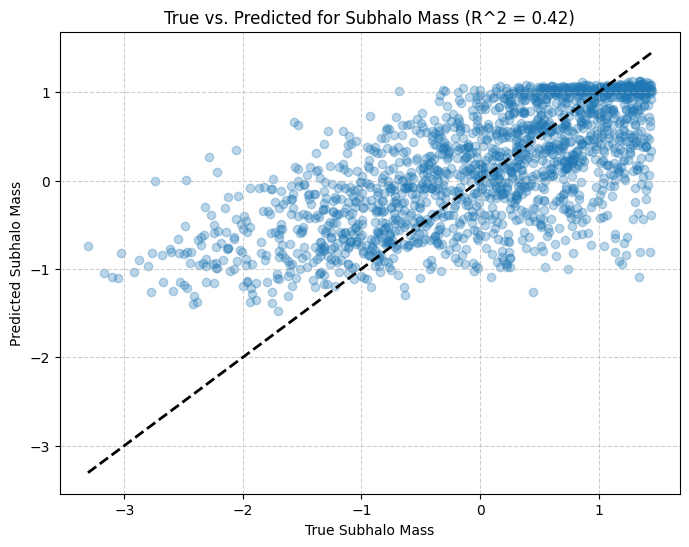

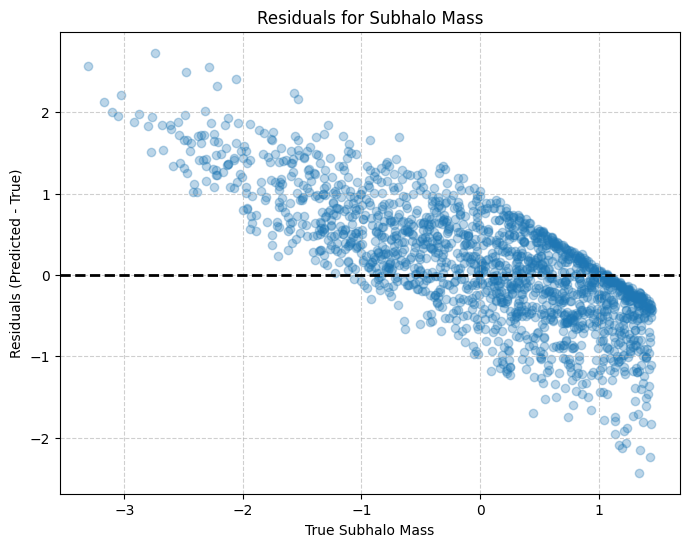


--- Metrics for Task: fsub ---
R^2 Score: 0.1145
Mean Squared Error (MSE): 0.8133
Root Mean Squared Error (RMSE): 0.9018


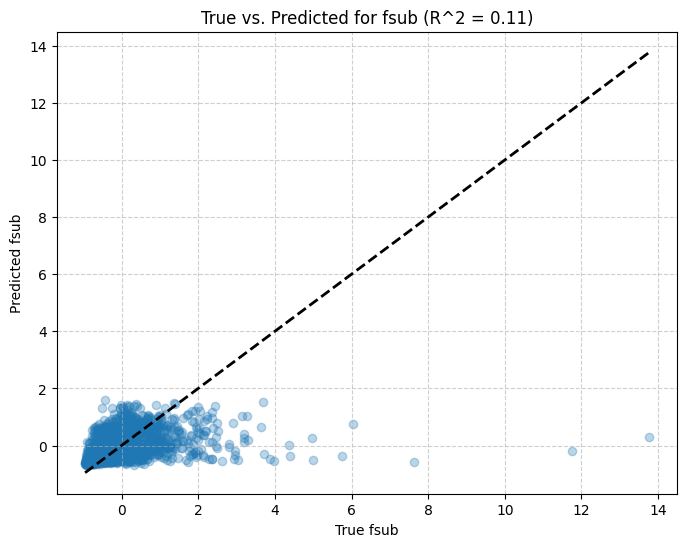

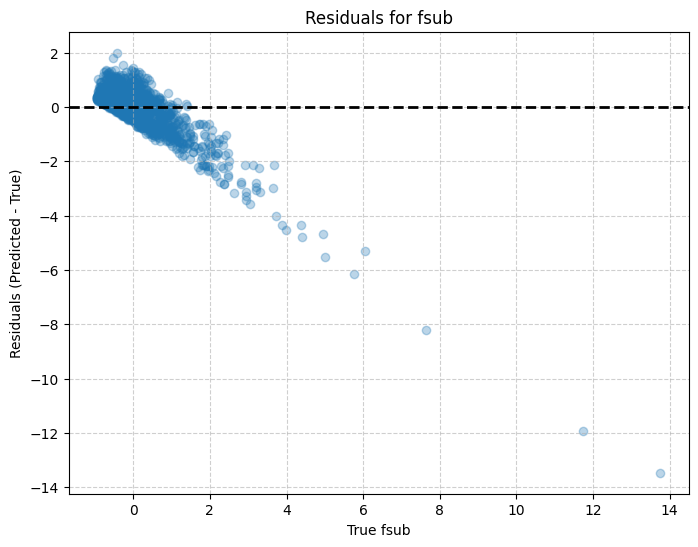


Metric evaluation complete.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model state dictionary
model = ResNet4Task()
model.load_state_dict(torch.load('lens_regressor_model.pth', map_location=device))
model.to(device)
model.eval() # Set the model to evaluation mode

all_targets = []
all_predictions = []

# Evaluate the model on the validation set to get predictions and true targets
with torch.no_grad():
    for images, targets, redshifts in val_dataloader:
        images, targets, redshifts = images.to(device), targets.to(device), redshifts.to(device)
        outputs = model(images, redshifts)

        all_targets.append(targets.cpu().numpy())
        all_predictions.append(outputs.cpu().numpy())

all_targets = np.concatenate(all_targets, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Calculate metrics for each of the 4 tasks
# Using R^2 as a metric for regression tasks
from sklearn.metrics import r2_score, mean_squared_error

task_names = ['Main Halo Mass', 'Sigma_v', 'Subhalo Mass', 'fsub']

for i in range(all_targets.shape[1]):
    task_targets = all_targets[:, i]
    task_predictions = all_predictions[:, i]

    r2 = r2_score(task_targets, task_predictions)
    mse = mean_squared_error(task_targets, task_predictions)
    rmse = np.sqrt(mse)

    print(f"\n--- Metrics for Task: {task_names[i]} ---")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    #Plotting Predictions vs True Values
    plt.figure(figsize=(8, 6))
    plt.scatter(task_targets, task_predictions, alpha=0.3)
    plt.plot([task_targets.min(), task_targets.max()], [task_targets.min(), task_targets.max()], 'k--', lw=2) # Identity line
    plt.xlabel(f"True {task_names[i]}")
    plt.ylabel(f"Predicted {task_names[i]}")
    plt.title(f"True vs. Predicted for {task_names[i]} (R^2 = {r2:.2f})")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    #Plotting Residuals
    residuals = task_predictions - task_targets
    plt.figure(figsize=(8, 6))
    plt.scatter(task_targets, residuals, alpha=0.3)
    plt.axhline(0, color='k', linestyle='--', lw=2)
    plt.xlabel(f"True {task_names[i]}")
    plt.ylabel("Residuals (Predicted - True)")
    plt.title(f"Residuals for {task_names[i]}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

print("\nMetric evaluation complete.")

In [ ]:
""" ROC Curve Plotting Function"""
def plot_roc_curve(all_preds, all_labels):
    print("Generating ROC Curve")

    # Convert predictions and labels to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        print(f"Class {i} ROC AUC: {roc_auc[i]:.4f}")

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    class_names = ['Axion', 'CDM', 'No Substructure']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('/content/drive/MyDrive/Model_III_dataset/roc_curve.png')
    plt.close()

    print("ROC Curve saved as roc_curve.png")


plot_roc_curve(all_preds, all_labels)

print("Training and Evaluation Complete!")